<a href="https://colab.research.google.com/github/HindumathiR/loan-eligibility-prediction/blob/main/loan_eligibility_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# loan_train_colab_safe.py

from pathlib import Path
import argparse
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

SEED = 42

def load_data(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    return df

def preprocess(df: pd.DataFrame):
    y = df["Loan_Status"].map({"Y": 1, "N": 0})
    X = df.drop(["Loan_ID", "Loan_Status"], axis=1)

    num_feats = ["ApplicantIncome", "CoapplicantIncome",
                 "LoanAmount", "Loan_Amount_Term"]
    cat_feats = ["Gender", "Married", "Dependents", "Education",
                 "Self_Employed", "Credit_History", "Property_Area"]

    # Fill missing values
    X[num_feats] = X[num_feats].fillna(X[num_feats].median())
    X[cat_feats] = X[cat_feats].fillna(X[cat_feats].mode().iloc[0])

    return X, y, num_feats, cat_feats

def build_pipeline(num_feats, cat_feats) -> Pipeline:
    numeric_pipe = Pipeline([("scaler", StandardScaler())])
    categorical_pipe = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))])

    preprocessor = ColumnTransformer([
        ("num", numeric_pipe, num_feats),
        ("cat", categorical_pipe, cat_feats)
    ])

    classifier = LogisticRegression(max_iter=1000, random_state=SEED)
    return Pipeline([("pre", preprocessor), ("clf", classifier)])

def train_and_eval(data_path: Path, save_path: Path):
    df = load_data(data_path)
    X, y, num_feats, cat_feats = preprocess(df)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=SEED
    )

    pipe = build_pipeline(num_feats, cat_feats)
    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)
    print("\n✅ Classification Report:\n")
    print(classification_report(y_test, preds, target_names=["Rejected", "Approved"]))
    print(f"✅ Accuracy: {accuracy_score(y_test, preds):.4f}")

    joblib.dump(pipe, save_path)
    print(f"\n📦 Model saved to: {save_path.resolve()}")

# ✅ Safe for Colab and Jupyter
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Train Loan Eligibility Model")
    parser.add_argument(
        "--data",
        type=Path,
        default=Path("/content/loantrain.csv.csv"),  # Your file path
        help="Path to train.csv with Loan_Status"
    )
    parser.add_argument(
        "--save",
        type=Path,
        default=Path("loan_model.joblib"),
        help="Where to store the fitted model"
    )
    args, _ = parser.parse_known_args()  # <- avoids Jupyter's -f argument crash
    train_and_eval(args.data, args.save)



✅ Classification Report:

              precision    recall  f1-score   support

    Rejected       0.96      0.58      0.72        38
    Approved       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123

✅ Accuracy: 0.8618

📦 Model saved to: /content/loan_model.joblib


In [4]:
import pandas as pd
import joblib

# 1. Load test data
test_df = pd.read_csv("/content/loantest.csv.csv")

# 2. Load trained model
model = joblib.load("/content/loan_model.joblib")

# 3. Backup Loan_ID for submission
test_ids = test_df["Loan_ID"]

# 4. Define numerical and categorical columns
num_feats = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]
cat_feats = ["Gender", "Married", "Dependents", "Education",
             "Self_Employed", "Credit_History", "Property_Area"]

# 5. Handle missing values (same as training)
test_df[num_feats] = test_df[num_feats].fillna(test_df[num_feats].median())
test_df[cat_feats] = test_df[cat_feats].fillna(test_df[cat_feats].mode().iloc[0])

# 6. Drop Loan_ID before prediction
X_test = test_df.drop("Loan_ID", axis=1)

# 7. Predict with model (gives 0 or 1)
predictions = model.predict(X_test)

# 8. Convert 0 → 'N' and 1 → 'Y'
labels = pd.Series(predictions).map({0: "N", 1: "Y"})

# 9. Create final submission DataFrame
submission = pd.DataFrame({
    "Loan_ID": test_ids,
    "Loan_Status": labels
})

# 10. Save to CSV
submission.to_csv("/content/submission.csv", index=False)
print("✅ submission.csv saved successfully!")


✅ submission.csv saved successfully!


In [5]:
import pandas as pd
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Path to your labelled training data
DATA_PATH = Path("/content/loantrain.csv.csv")  # adjust if needed
df = pd.read_csv(DATA_PATH)

# Feature groups
NUM = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]
CAT = ["Gender", "Married", "Dependents", "Education",
       "Self_Employed", "Credit_History", "Property_Area"]

# Basic imputations
df[NUM] = df[NUM].fillna(df[NUM].median())
df[CAT] = df[CAT].fillna(df[CAT].mode().iloc[0])

X = df.drop(["Loan_ID", "Loan_Status"], axis=1)
y = df["Loan_Status"].map({"Y": 1, "N": 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pre = ColumnTransformer([
    ("num", Pipeline([("scaler", StandardScaler())]), NUM),
    ("cat", Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))]), CAT)
])


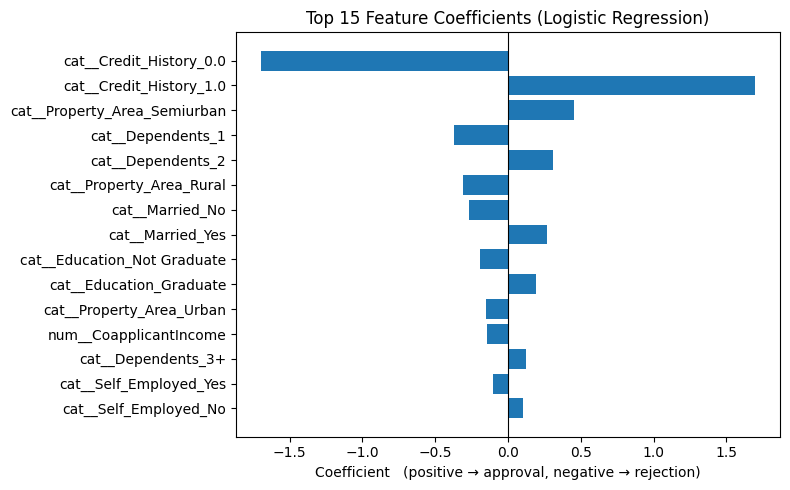

In [6]:
import matplotlib.pyplot as plt
import numpy as np

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_pipe = Pipeline([("pre", pre), ("clf", log_clf)])
log_pipe.fit(X_train, y_train)

feature_names = log_pipe.named_steps["pre"].get_feature_names_out()
coefs = log_pipe.named_steps["clf"].coef_[0]
imp_df = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
      .assign(importance=lambda d: d["coef"].abs())
      .nlargest(15, "importance")
      .sort_values("importance")
)

plt.figure(figsize=(8, 5))
plt.barh(imp_df["feature"], imp_df["coef"])
plt.axvline(0, color="black", linewidth=0.8)
plt.title("Top 15 Feature Coefficients (Logistic Regression)")
plt.xlabel("Coefficient   (positive → approval, negative → rejection)")
plt.tight_layout()
plt.show()


In [7]:
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l2", "l1"],
    "clf__solver": ["liblinear"],  # supports l1 and l2
}
gs = GridSearchCV(
    estimator=Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=1000, random_state=42))]),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
gs.fit(X_train, y_train)

print("Best CV accuracy:", gs.best_score_)
print("Best params:", gs.best_params_)

best_log_pipe = gs.best_estimator_
print("Test accuracy:", accuracy_score(y_test, best_log_pipe.predict(X_test)))


Best CV accuracy: 0.7983714698000413
Best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Test accuracy: 0.8617886178861789


In [8]:
rf_pipe = Pipeline([
    ("pre", pre),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
])
rf_pipe.fit(X_train, y_train)

print("LogReg test acc:", accuracy_score(y_test, best_log_pipe.predict(X_test)))
print("RandomForest test acc:", accuracy_score(y_test, rf_pipe.predict(X_test)))


LogReg test acc: 0.8617886178861789
RandomForest test acc: 0.8130081300813008


In [10]:
from xgboost import XGBClassifier
xgb_pipe = Pipeline([
    ("pre", pre),
    ("clf", XGBClassifier(
        n_estimators=500, learning_rate=0.1,
        max_depth=5, subsample=0.8, objective="binary:logistic",
        random_state=42, eval_metric="logloss"))
])


In [16]:
import streamlit as st
import pandas as pd
import joblib

# Load model
model = joblib.load("/content/loan_model.joblib")

st.title("🏦 Loan Eligibility Predictor")
st.markdown("Enter applicant details to check if loan will be approved.")

# Input widgets
gender = st.selectbox("Gender", ["Male", "Female"])
married = st.selectbox("Married", ["Yes", "No"])
dependents = st.selectbox("Dependents", ["0", "1", "2", "3+"])
education = st.selectbox("Education", ["Graduate", "Not Graduate"])
self_employed = st.selectbox("Self Employed", ["No", "Yes"])
credit_history = st.selectbox("Credit History", [1.0, 0.0])
property_area = st.selectbox("Property Area", ["Urban", "Semiurban", "Rural"])
applicant_income = st.number_input("Applicant Income", min_value=0)
coapplicant_income = st.number_input("Coapplicant Income", min_value=0)
loan_amount = st.number_input("Loan Amount (in thousands)", min_value=0)
loan_term = st.number_input("Loan Term (in months)", min_value=0, value=360)

# Predict button
if st.button("Check Loan Status"):
    row = pd.DataFrame([{
        "Gender": gender,
        "Married": married,
        "Dependents": dependents,
        "Education": education,
        "Self_Employed": self_employed,
        "Credit_History": credit_history,
        "Property_Area": property_area,
        "ApplicantIncome": applicant_income,
        "CoapplicantIncome": coapplicant_income,
        "LoanAmount": loan_amount,
        "Loan_Amount_Term": loan_term
    }])

    pred = model.predict(row)[0]
    proba = model.predict_proba(row)[0][1]

    if pred == 1:
        st.success(f"✅ Loan Approved! (Probability: {proba:.2f})")
    else:
        st.error(f"❌ Loan Rejected (Probability: {proba:.2f})")


2025-07-16 14:04:27.693 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-16 14:04:28.118 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-16 14:04:28.121 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-16 14:04:28.124 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-16 14:04:28.126 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-16 14:04:28.127 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-16 14:04:28.131 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-16 14:04:28.136 Thread 'MainThread': mi

In [15]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.3 MB/s eta 0:00:00
